<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# CAMS Fire monitoring

### About

This notebook provides you a practical introduction to the topic of how to compute climatologies and anomalies on different spatial and temporal levels.

The notebooks has four sections. The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts. Sections 2 to 4 are practical examples of how to compute and analyse climatologies and anomalies on different spatial (global and regional) and temporal (annual, monthly and seasonal) levels.

The notebook has the following outline:

* [1 - Data preparation](#data_preparation)
* [2 - Calculation of the annual global mean surface air temperature anomaly](#global_mean)
* [3 - Calculation of the monthly surface air temperature anomaly in Europe](#monthly_europe)
* [4 - Calculation of seasonal variations of near-surface air temperature over the Arctic](#seasonal_arctic)

### Data

This notebook introduces you to the ERA5 reanalysis monthly averaged data on single levels. The data has the following specifications:

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Jan 1979 to Dec 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<br>

<hr>

### Load libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Variable (Single level): `Organic matter aerosol optical depth at 550nm`
- Date: Start: `2021-08-01`, End: `2021-08-08`
- Time: `00:00` (default)
- Leadtime hour: `0, 6, 12, 18`
- Type: `Forecast` (default)
- Area: Restricted area: `North: 80`, `East: -50`, `South: 25`, `West: -150` 
- Format: `Zipped netCDF (experimental)`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data using ADS API

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [37]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2021-08-01/2021-08-08',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': 'organic_matter_aerosol_optical_depth_550nm',
        'time': '00:00',
        'leadtime_hour': [
            '0', '12', '18',
            '6',
        ],
        'area': [
            80, -150, 25,
            -50,
        ],
    },
    f'{DATADIR}/2021-08_NAmerica_organicMatterAOD.zip')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-09-15 14:37:01,774 INFO Welcome to the CDS
2021-09-15 14:37:01,778 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-09-15 14:37:01,842 INFO Request is completed
2021-09-15 14:37:01,846 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-00

Result(content_length=2219756,content_type=application/zip,location=https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data5/adaptor.mars_constrained.internal-1629130472.331898-14316-15-bf208880-3d10-4fda-b4c4-60733dd5484b.zip)

### Read data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for gridded (array-based) scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

First we extract the downloaded zip file:

In [38]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/2021-08_NAmerica_organicMatterAOD.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}/2021-08_NAmerica_organicMatterAOD/')

For convenience, we create a variable with the name of our downloaded file:

In [39]:
fn = f'{DATADIR}/2021-08_NAmerica_organicMatterAOD/data.nc'

Now we can read the data into an Xarray dataset:

In [40]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)

Let's see how this looks by querying our newly created Xarray dataset ...

In [41]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 138, longitude: 251, time: 32)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-16 16:14:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

We see that the dataset has one variable called **"omaod550"**, which stands for "Organic Matter Aerosol Optical Depth at 550nm", and three coordinates of **longitude**, **latitude** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **omaod550** data easier, we convert in into an Xarray data array.

In [42]:
# Create Xarray Data Array
da = ds['omaod550']

In [43]:
da

<xarray.DataArray 'omaod550' (time: 32, latitude: 138, longitude: 251)>
[1108416 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

To visualise this data we will create an animation, with each frame corresponding to a time step. These include forecasts for each day at lead times of 0, 6, 12 and 18 hours.

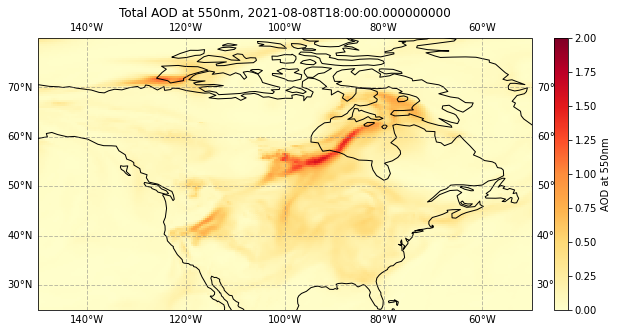

In [53]:
n = da.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
    ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) # Specify geographical extent
    ax.coastlines(color='black') # Add coastlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Total AOD at 550nm, {da.time[i].values}', fontsize=12) # Set figure title
    im = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data, iterating over time
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('AOD at 550nm') # Define the colourbar label
    plt.show() # Display the figure
    sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation

The animation clearly shows the high values of organic matter aerosol optical depth originating from the many different wildfires burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

The animation also shows these high values crossing the continent to the east coast where it still affects local air quality.

## <a id='era5_fire'></a>C3S ERA5 soil moisture & CAMS fire data

### Search for data on the CDS

To search for data, visit the CDS website: http://cds.climate.copernicus.eu To facilitate your search you can use keywords, or apply various filters.

The data we are going to use in this exercise is the ERA5 monthly averaged reanalysis data on single levels from 1979 to present. We are going to download volumetric soil water at layer 1. This parameter is the volume of water in soil layer 1 (0 - 7cm, the surface is at 0cm). We will download data only over the Arctic. We would like to view the anomalies for summer 2019, but the data comes in monthly means. To calculate the anomalies we will subtract from the 2019 data the average of the time series from 1981 to 2010.

Using the filters, or keywords, search for the dataset `ERA5 monthly averaged data on single levels from 1979 to present`.

<img src='./img/CDS.jpg' align='left' width='45%'></img> <img src='./img/CDS_ERA5.jpg' align='right' width='45%'></img> 

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Monthly averaged reanalysis`
- Variable: `Volumetric soil water layer 1`
- Year: `1981,...2010,2019`
- Month: `June, July, August`
- Time: `00:00` (default)
- Geographical area: `North: 90`, `East: 180`, `South: 66`, `West: -180` 
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data using CDS API

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [ ]:
c = cdsapi.Client(url=CDS_URL, key=CDS_KEY)
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'volumetric_soil_water_layer_1',
        'year': [
            '1981', '1982', '1983',
            '1984', '1985', '1986',
            '1987', '1988', '1989',
            '1990', '1991', '1992',
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2019',
        ],
        'month': [
            '06', '07', '08',
        ],
        'time': '00:00',
        'area': [
            90, -180, 66,
            180,
        ],
        'format': 'netcdf',
    },
    f'{DATADIR}/ERA5_vsm.nc')

### Read ERA5 data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

First we create a variable with the name of our downloaded file:

In [3]:
fn = f'{DATADIR}/ERA5_vsm.nc'

Now we can read the data into an Xarray dataset:

In [4]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)

Let's see how this looks by querying our newly created Xarray dataset ...

In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 1440, time: 93)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 66.5 66.25 66.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2019-08-01
Data variables:
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-20 11:04:20 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

We see that the dataset has one variable called **"swvl1"**, which stands for "volumetric_soil_water_layer_1", and three coordinates of **longitude**, **latitude** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **swvl1** data easier, we convert in into an Xarray data array.

In [6]:
# Create Xarray Data Array
da = ds['swvl1']

### View and plot soil moisture data, and compare with fire locations

Now the fun part begins! Once our data is in a convenient format, there is no limit to what we can do with it! For example we can finally visualise the data to see what information it can provide.

We are interested in viewing anomalies for 2019 with respect to the long term average (climatology), so we will first need to calculate the climatology for the period 1981 to 2010.

For efficiency we first calculate the yearly means (average of JJA for each year):

In [7]:
yearly_mean = da.groupby('time.year').mean('time')

Here we subset data for the period 1981 to 2010:

In [8]:
ref = yearly_mean.where((yearly_mean.year > 1980) & (yearly_mean.year < 2011), drop=True)

Now we can calculate the mean for 1981-2010:

In [9]:
ref_mean = ref.mean(dim="year")

Here we calculate the yearly mean for 2019:

In [10]:
swv_2019 = yearly_mean.where((yearly_mean.year == 2019), drop=True)
swv_2019 = swv_2019.mean(dim="year")

### Calculate anomalies

We will now calculate anomalies, defined as deviations from the reference mean. We multiply this by 100 to convert to percentages.

In [11]:
swv_an_2019 = (swv_2019 - ref_mean) * 100.

Let's inspect the newly created anomaly data.

In [12]:
swv_an_2019

<xarray.DataArray 'swvl1' (latitude: 97, longitude: 1440)>
array([[ 1.4210855e-11,  1.4210855e-11,  1.4210855e-11, ...,
         1.4210855e-11,  1.4210855e-11,  1.4210855e-11],
       [ 1.4210855e-11,  1.4210855e-11,  1.4210855e-11, ...,
         1.4210855e-11,  1.4210855e-11,  1.4210855e-11],
       [ 1.4210855e-11,  1.4210855e-11,  1.4210855e-11, ...,
         1.4210855e-11,  1.4210855e-11,  1.4210855e-11],
       ...,
       [-1.3383687e+00, -9.9414587e-01, -4.8720837e-01, ...,
         1.6953945e-01, -2.6411116e-01, -9.9717081e-01],
       [ 9.6029043e-01,  2.9694587e-01, -3.7146211e-01, ...,
         3.6236346e-01, -3.1501055e-02,  4.6666861e-01],
       [-2.6646852e-01, -8.5413456e-01, -3.4183040e-01, ...,
         9.6756220e-01,  3.5119653e-01, -6.5770745e-01]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 66.5 66.25 66.0

### Read Fire Radiative Power (FRP) data from CAMS catalogue

We would like to compare the soil moisture data in the Arctic with fire locations. These we can obtain from the CAMS Catalogue https://atmosphere.copernicus.eu/catalogue#/, from the dataset: `NRT Biomass burning emissions of carbon and various trace species based on assimilated Fire Radiative Power (FRP) (GFAS)`. Following the links in the CAMS Catalogue will lead you to the CAMS Global Fire Assimilation System (GFAS) catalogue https://apps.ecmwf.int/datasets/data/cams-gfas/, where you can select the various parameters, date ranges, etc. that you are interested in.

For the purposes of this tutorial, and to reduce the data volume, we will use a preprocessed version of the fire radiative power data. This is available in your data folder with the name `cams_gfas_arctic_jun-aug_2019.csv`.

In [13]:
fn = f'{DATADIR}/cams_gfas_arctic_jun-aug_2019.csv'
df = pd.read_csv(fn)

Let's view this data:

In [14]:
df

,Date,Longitude (deg E),Latitude (deg N),Wildfire radiative power (Gigawatts per day)
0,20190601,-51.65,67.35,0.002496
1,20190601,-51.65,67.85,0.007972
2,20190601,70.95,66.15,0.012929
3,20190601,70.95,66.25,0.029266
4,20190601,71.05,66.15,0.011182
...,...,...,...,...
16617,20190831,136.45,67.45,0.005863
16618,20190831,136.75,67.65,0.001069
16619,20190831,140.55,69.25,0.041437
16620,20190831,140.65,69.25,0.002047


For simplicity in subsequent plots, we will rename some of the columns to make them shorter.

In [15]:
# rename columns for simplicity
df.rename(columns={"Longitude (deg E)": "longitude", 
                   "Latitude (deg N)": "latitude", 
                   "Wildfire radiative power (Gigawatts per day)": "frp"}, 
          inplace=True)

### View and plot soil moisture data, and compare with fire locations

Now we can compare the soil moisture anomalies in the Arctic for JJA 2019, with fire locations for the same period in a map:

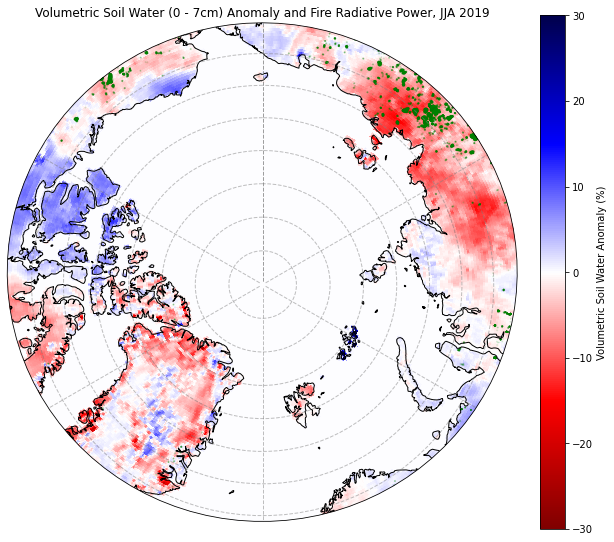

In [16]:
# create the figure panel 
fig = plt.figure(figsize=(10,10))

# create the projections, centred on North Pole
ortho = ccrs.Orthographic(central_longitude=0, central_latitude=90)
geo = ccrs.Geodetic()

# create the map using the cartopy Orthographic projection
ax = plt.subplot(1,1,1, projection=ortho)

# transform lat/lons points to othographic points
points = ortho.transform_points(geo, df['longitude'].values, 
                                    df['latitude'].values)
# add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# compute a circle in axes coordinates, which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set boundary
ax.set_extent([-180,180, 66.05,90], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

# provide a title
ax.set_title('Volumetric Soil Water (0 - 7cm) Anomaly and Fire Radiative Power, JJA 2019', fontsize=12)

# plot data (soil moisture and FRP)
im = plt.pcolormesh(swv_an_2019.longitude.values, swv_an_2019.latitude.values,
                    swv_an_2019, cmap='seismic_r', vmin=-30, vmax=30, transform=ccrs.PlateCarree())
ax.scatter(points[:, 0], points[:, 1], 
           c='green', s=(2**df['frp']), alpha=0.1, label='FRP')

# add colourbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label(label='Volumetric Soil Water Anomaly (%)')

# save figure as PNG file
fig.savefig(f'{DATADIR}/SM_FRP_JJA2019.png')

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>